In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
import torch
import torch.nn.functional as F
import pyro

In [4]:
from monteloanco import Model, Guide, GroupedBatchSampler, tmat_reshape, Template

We take a subset of the 2+ million accounts available here for speed.

In [5]:
df_train = pd.read_json('training.jsonl.gz', lines=True)
pd.testing.assert_index_equal(df_train.index, pd.RangeIndex(0, len(df_train)))

In [6]:
df_train.pymnt = df_train.pymnt.apply(torch.tensor)

The model has been designed such that it can train / simulate a large number of accounts in parallel on a GPU. If you don't have a suitable GPU installed on your machine simply replace `cuda:0` here with `cpu`. To achieve this we need to consider how the data is to be fed into the model. One of consideration with batching the tasks is that it is preferable to present the longest sequences first as these contain the most information, but more importanly than that, that all sequences in a batch ultimately have the same length. We pad the sequences out with 0, which is perfectly applicable to both the expected and realised payment seqences.

In [7]:
device = 'cuda:0'

In [8]:
batch_size = 100_000
dataset = df_train[['id', 'loan_amnt', 'int_rate', 'installment', 'n_report_d', 'total_pre_chargeoff']].to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

With the dataset batches defined it's time to run the optimisation process, and tune the parameters. The loss here is the difference between the anticipated payment and that that was made, for every account, up to and including each timestep in the sequence.

In [9]:
from torch.utils.data import DataLoader

In [10]:
pyro.get_param_store().load('param_store.pt')

/home/daniel/miniconda3/envs/pytorch/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(input_file

In [11]:
model = Model(embedding_size=4, device=device)
model.load_state_dict(torch.load('model_params.pt', weights_only=True))

<All keys matched successfully>

In [12]:
guide = Guide(embedding_size=4, device=device)
guide.load_state_dict(torch.load('guide_params.pt', weights_only=True))

<All keys matched successfully>

Above you can see the progress made by the optimiser in reducing the loss. Now we can take a look at some results, and sense-check the outcome. First we'll look at the (average) transition matrix itself seeing this is what lies at the core of the model. Hopefully you can see the similarities between this and the demo I made above.

In [13]:
df_tmat = pd.DataFrame()
for batch_id, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    tmat = tmat_reshape(
        pyro.get_param_store()[f'embeddings_{batch_id}'],
        pyro.get_param_store()[f'model.weight1'],
        pyro.get_param_store()[f'model.bias1'],
        device
    )
    tmat_prior = pyro.get_param_store()[f'tmat_prior_{batch_id}']
    df_tmat_new = pd.DataFrame(zip(batch['id'].tolist(), tmat, tmat_prior)).reset_index()
    df_tmat_new['batch_id'] = batch_id
    df_tmat = pd.concat([df_tmat, df_tmat_new])

In [14]:
df_tmat = df_tmat.set_axis(['batch_idx', 'id', 'tmat', 'tmat_prior', 'batch_id'], axis=1)
df_tmat = df_tmat.merge(df_train, on='id')

In [15]:
def tmat_to_score(tmat):
    '''
    Function to identify probability of account being up to date after 12 months
    '''
    score = torch.zeros(8).to(device)
    score[1] = 1.
    for _ in range(12): score = torch.matmul(score, tmat)
    return score

In [16]:
df_tmat['score'] = df_tmat['tmat'].apply(lambda x: tmat_to_score(x)[7].item())
df_tmat['score_prior'] = df_tmat['tmat_prior'].apply(lambda x: tmat_to_score(x)[7].item())

In [17]:
df_tmat.drop(['tmat', 'tmat_prior', 'pymnt'], axis=1).to_csv('training.csv.gz', index=False)

### rank according to the model embeddings

Next we'll go into a little more detail, by looking at a few specific loan examples. To do this, we need to collapse the embeddings down to a single dimension representing the default probability after an arbitrarily long period of time. Naturally, this largely negates the purpose of determining a term-independent, multi-dimensional score in the first place, but for now we just need something to conveniently rank the accounts for the purposes of illustration. Think of this as being like a traditional credit score.

The 5 heatmaps reflect those accounts with the lowest probability of default, red cells in the first column indicate a high probability of being paid early. The transition heatmaps are followed by 50 simulations of each of these accounts and their cashflows which show for these 5 accounts, this was indeed the case.

In [18]:
df_tmat_head = df_tmat.sort_values('score').head(5)

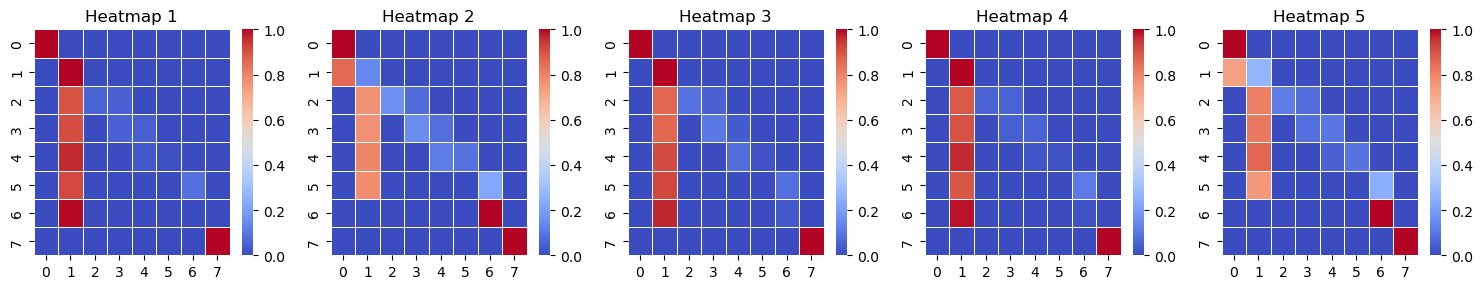

In [19]:
def plot_tmat(df_tmat, df_tmat_delta=None):

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        np_tmat = df_tmat.iloc[i].tmat.cpu().detach().numpy()
        if isinstance(df_tmat_delta, pd.DataFrame):
            np_tmat = np_tmat - df_tmat_delta.iloc[i].tmat.cpu().detach().numpy()
        sns.heatmap(np_tmat, ax=ax, linewidth=0.5, cmap='coolwarm')
        ax.set_title(f"Heatmap {i+1}")
    plt.tight_layout()
    plt.show()

plot_tmat(df_tmat_head)

The hidden state diagrams below tell a strong story for the accounts with the highest scores, most of these simulations converge on state 1 (up to date), and the corresponding actual cashflow profiles indicate these loans paying consistently for the duration of the term.

tensor(1056.8100, device='cuda:0', dtype=torch.float64) tensor(691.0900) 1056.81
tensor(5054.9451, device='cuda:0', dtype=torch.float64) tensor(5008.0098) 5911.92
tensor(463.3200, device='cuda:0', dtype=torch.float64) tensor(461.3700) 463.32
tensor(540.8400, device='cuda:0', dtype=torch.float64) tensor(545.8400) 540.84
tensor(6557.8256, device='cuda:0', dtype=torch.float64) tensor(6552.6001) 7323.12


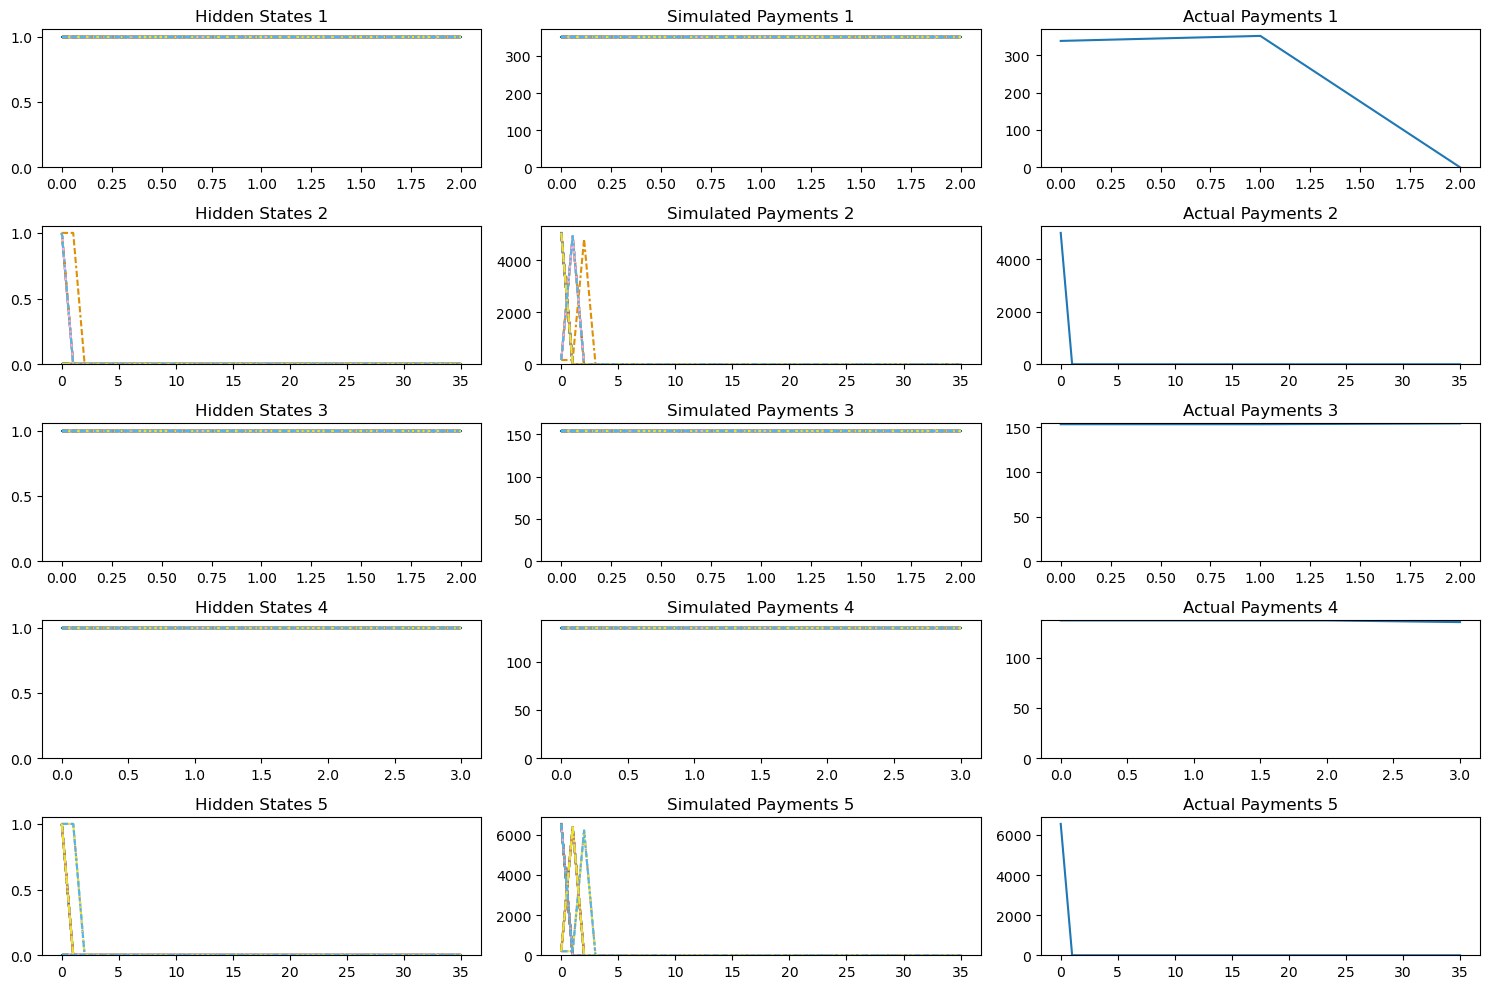

In [20]:
def plot_payments(df_tmat):
    
    fig, axes = plt.subplots(5, 3, figsize=(15, 10))
    for i, axs in enumerate(axes):
        loan = df_tmat.iloc[i]
        hidden_states, sim_pymnts, interest_paid, principal_paid = model.forward(
            loan.batch_id, 
            torch.tensor(loan.batch_idx).repeat(50).to(device), 
            torch.tensor(loan.installment).repeat(50).to(device),
            torch.tensor(loan.loan_amnt).repeat(50).to(device),
            torch.tensor(loan.int_rate).repeat(50).to(device),
            torch.tensor(loan.total_pre_chargeoff).repeat(50).to(device),
            loan.n_report_d)
        print(sim_pymnts.sum(0).mean(), loan.pymnt.sum(), loan.installment*len(loan.pymnt))
        sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
        sns.lineplot(sim_pymnts.detach().cpu().numpy(), ax=axs[1], palette='colorblind', legend=False)
        sns.lineplot(loan.pymnt.detach().cpu().numpy(), ax=axs[2], legend=False)
        axs[0].set_title(f"Hidden States {i+1}")
        axs[1].set_title(f"Simulated Payments {i+1}")
        axs[2].set_title(f"Actual Payments {i+1}")
        axs[0].set_ylim(0)
        axs[1].set_ylim(0)
        axs[2].set_ylim(0)
    plt.tight_layout()
    plt.show()

plot_payments(df_tmat_head)

The same data is then presented for the 5 accounts with the highest probability of default. These heatmaps are characterised by deep red cells in the final column, indicating a high probability of defaulting. In paractice it's not possible to transition directly from state 1 to state 7, and you see here how the cells one step off-diagonal to the right are more probable than most, illustrating how the delinqency states slowly escalate. 

In [21]:
df_tmat_tail = df_tmat.sort_values('score').tail(5)

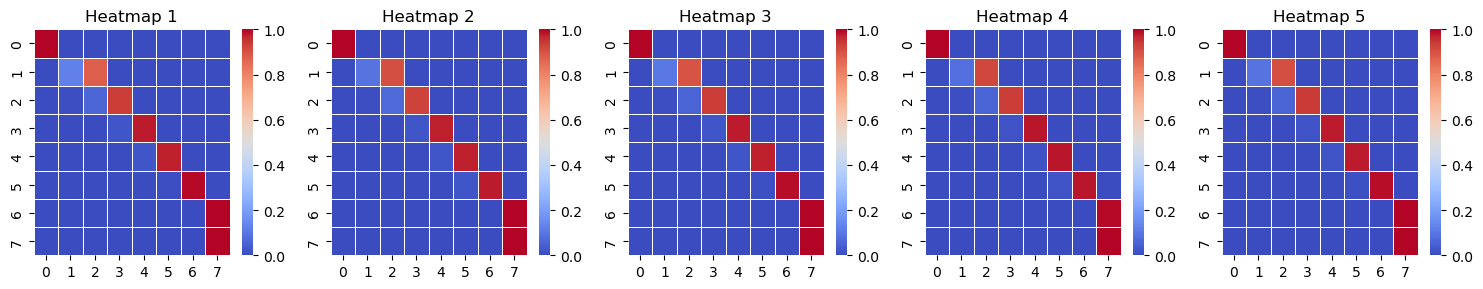

In [22]:
plot_tmat(df_tmat_tail)

And, in similar contast to the simulations above, most simulations here are rapidly transitioning to state 7 (charge-off) from where they no longer yield any payments (simulated payments line converges on 0). Looking at the actual payments we see why this is the case, as all these accounts are charged off befor ethey reached full term.

tensor(228.2448, device='cuda:0', dtype=torch.float64) tensor(0.) 1902.04
tensor(101.1864, device='cuda:0', dtype=torch.float64) tensor(0.) 1445.52
tensor(33.5104, device='cuda:0', dtype=torch.float64) tensor(0.) 1077.1200000000001
tensor(64.7296, device='cuda:0', dtype=torch.float64) tensor(0.) 2831.92
tensor(189.4320, device='cuda:0', dtype=torch.float64) tensor(0.) 3315.06


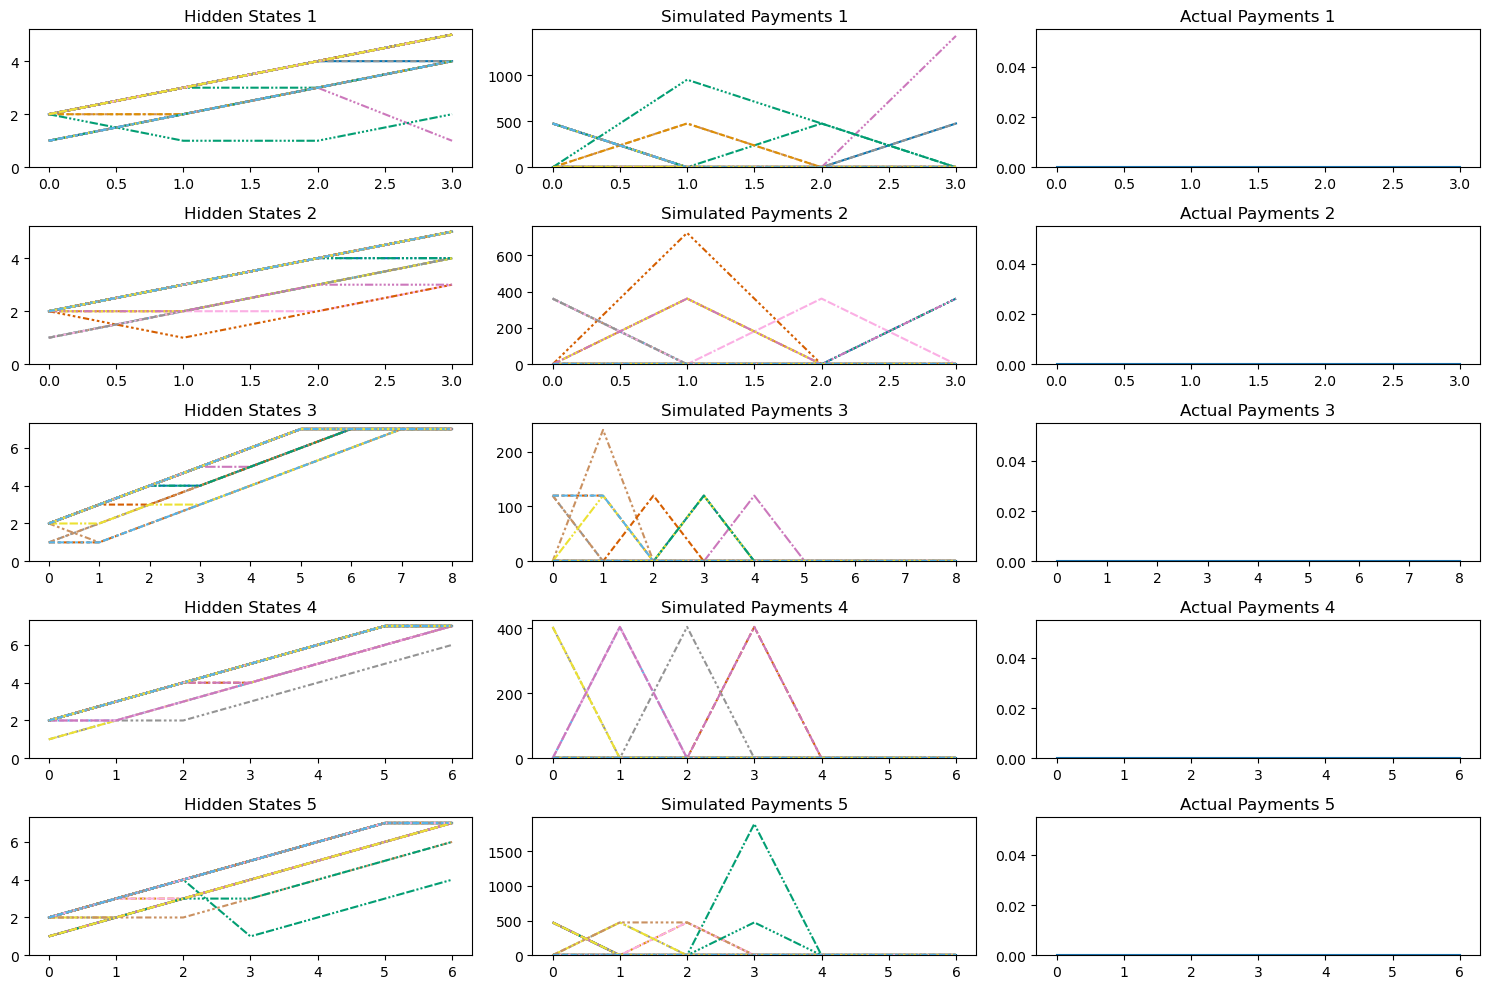

In [23]:
plot_payments(df_tmat_tail)

Finally, the differences between the highest and lowest scoring accounts' heatmaps can finally be seen below. The blue cells in column 1 illustrate those accounts remaining up to date (or catching up where they are late) and the red cells in column 7 indicates those accounts being charged off.

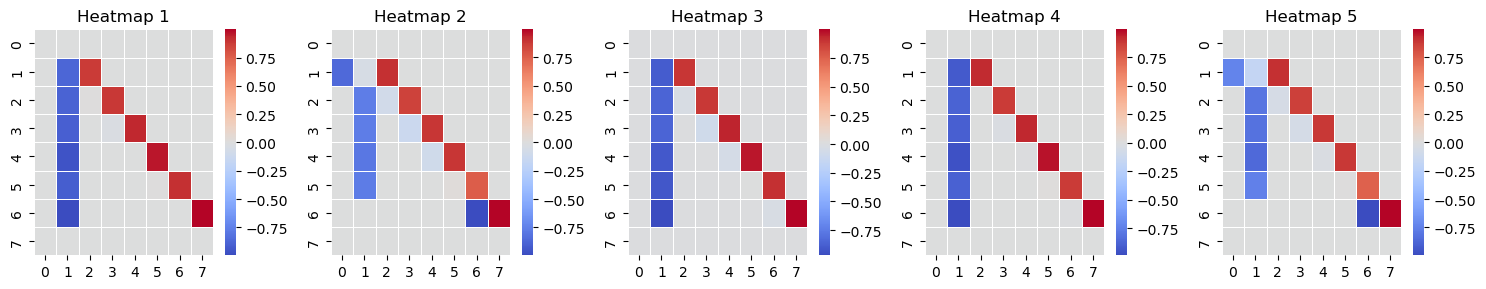

In [24]:
plot_tmat(df_tmat_tail, df_tmat_head)

### rank according to the guide

In [25]:
df_tmat_head = df_tmat.sort_values('score_prior').head(5)

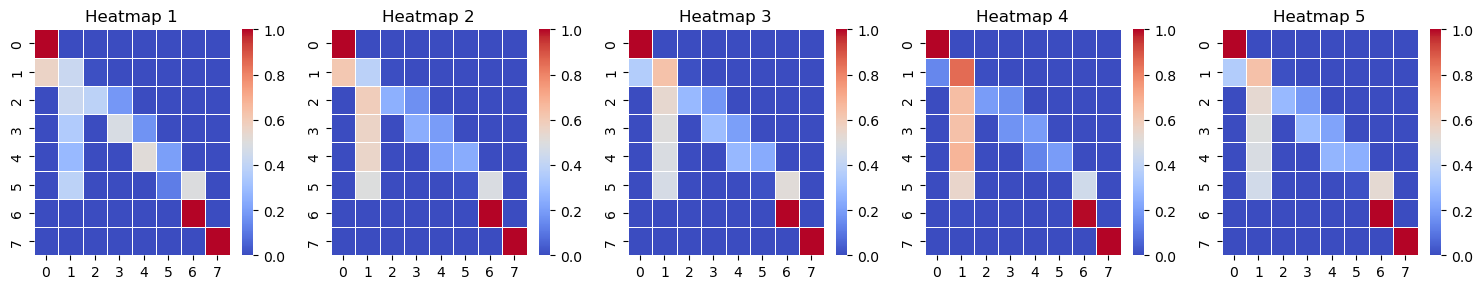

In [26]:
plot_tmat(df_tmat_head)

tensor(1227.8552, device='cuda:0', dtype=torch.float64) tensor(1214.5699) 1510.56
tensor(1023.1180, device='cuda:0', dtype=torch.float64) tensor(913.6700) 659.1099999999999
tensor(1037.6183, device='cuda:0', dtype=torch.float64) tensor(1047.5801) 1253.52
tensor(1052.3945, device='cuda:0', dtype=torch.float64) tensor(1125.8569) 1007.5
tensor(5126.6779, device='cuda:0', dtype=torch.float64) tensor(5596.2173) 3269.8


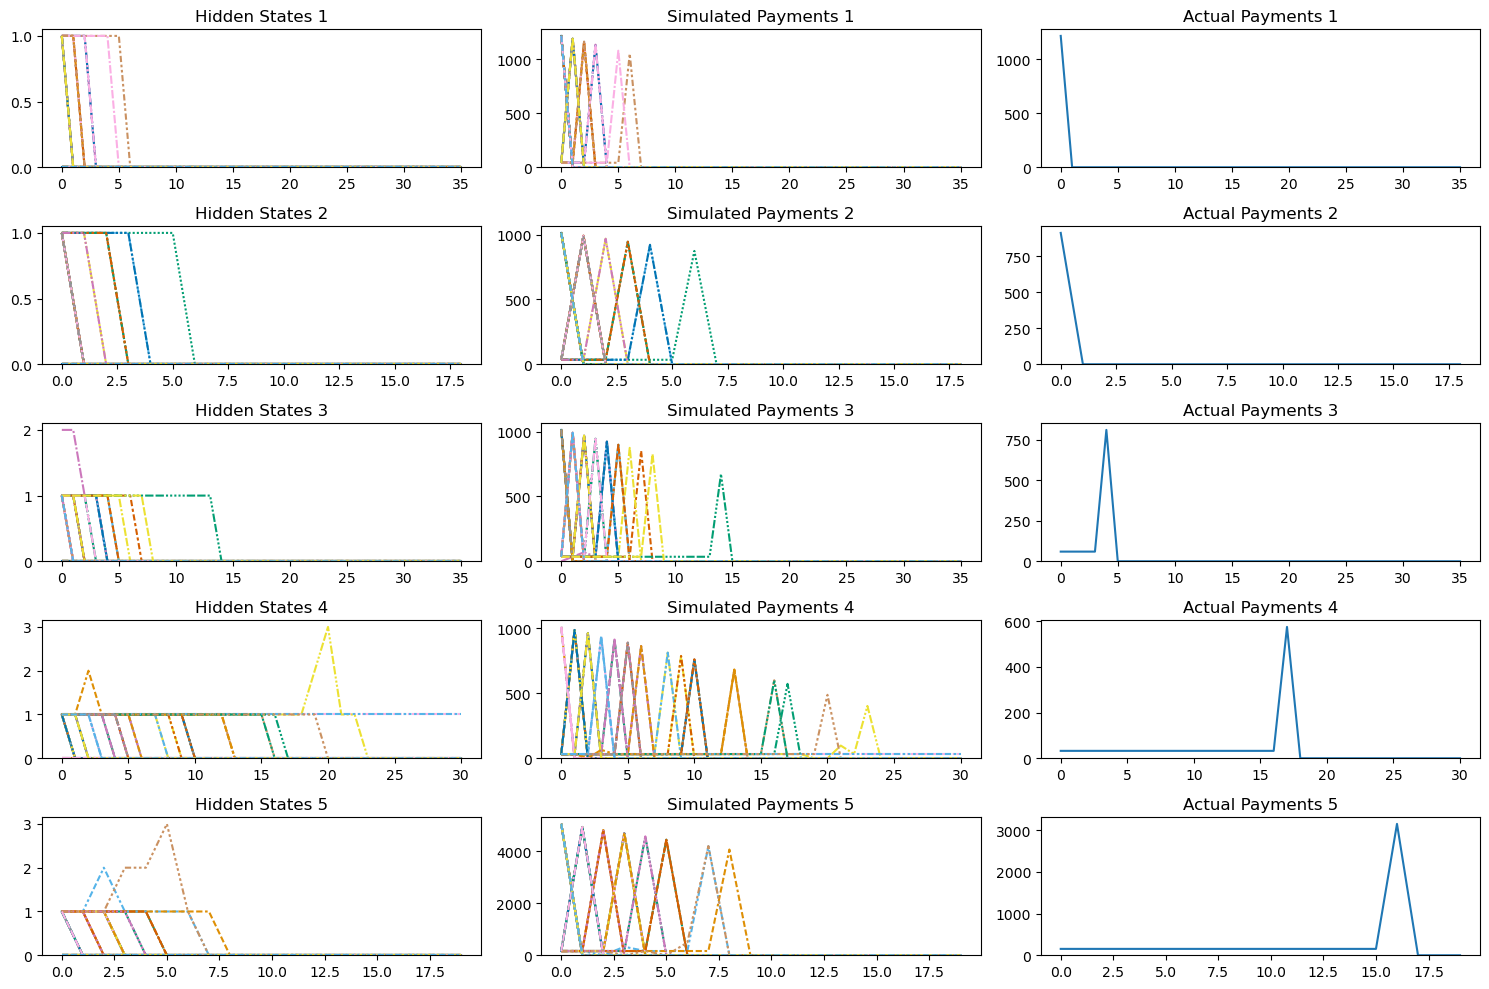

In [27]:
plot_payments(df_tmat_head)

In [28]:
df_tmat_tail = df_tmat.sort_values('score_prior').tail(5)

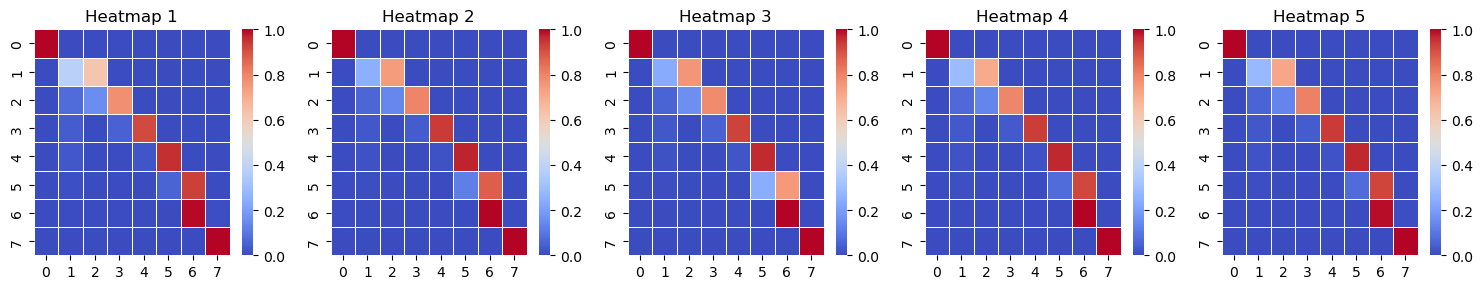

In [29]:
plot_tmat(df_tmat_tail)

tensor(1920.6090, device='cuda:0', dtype=torch.float64) tensor(1100.6500) 3765.8999999999996
tensor(2095.6552, device='cuda:0', dtype=torch.float64) tensor(1397.5900) 3867.82
tensor(6779.3390, device='cuda:0', dtype=torch.float64) tensor(4897.3999) 11722.2
tensor(4375.6362, device='cuda:0', dtype=torch.float64) tensor(3103.5100) 7479.719999999999
tensor(1429.4752, device='cuda:0', dtype=torch.float64) tensor(1027.9600) 3122.64


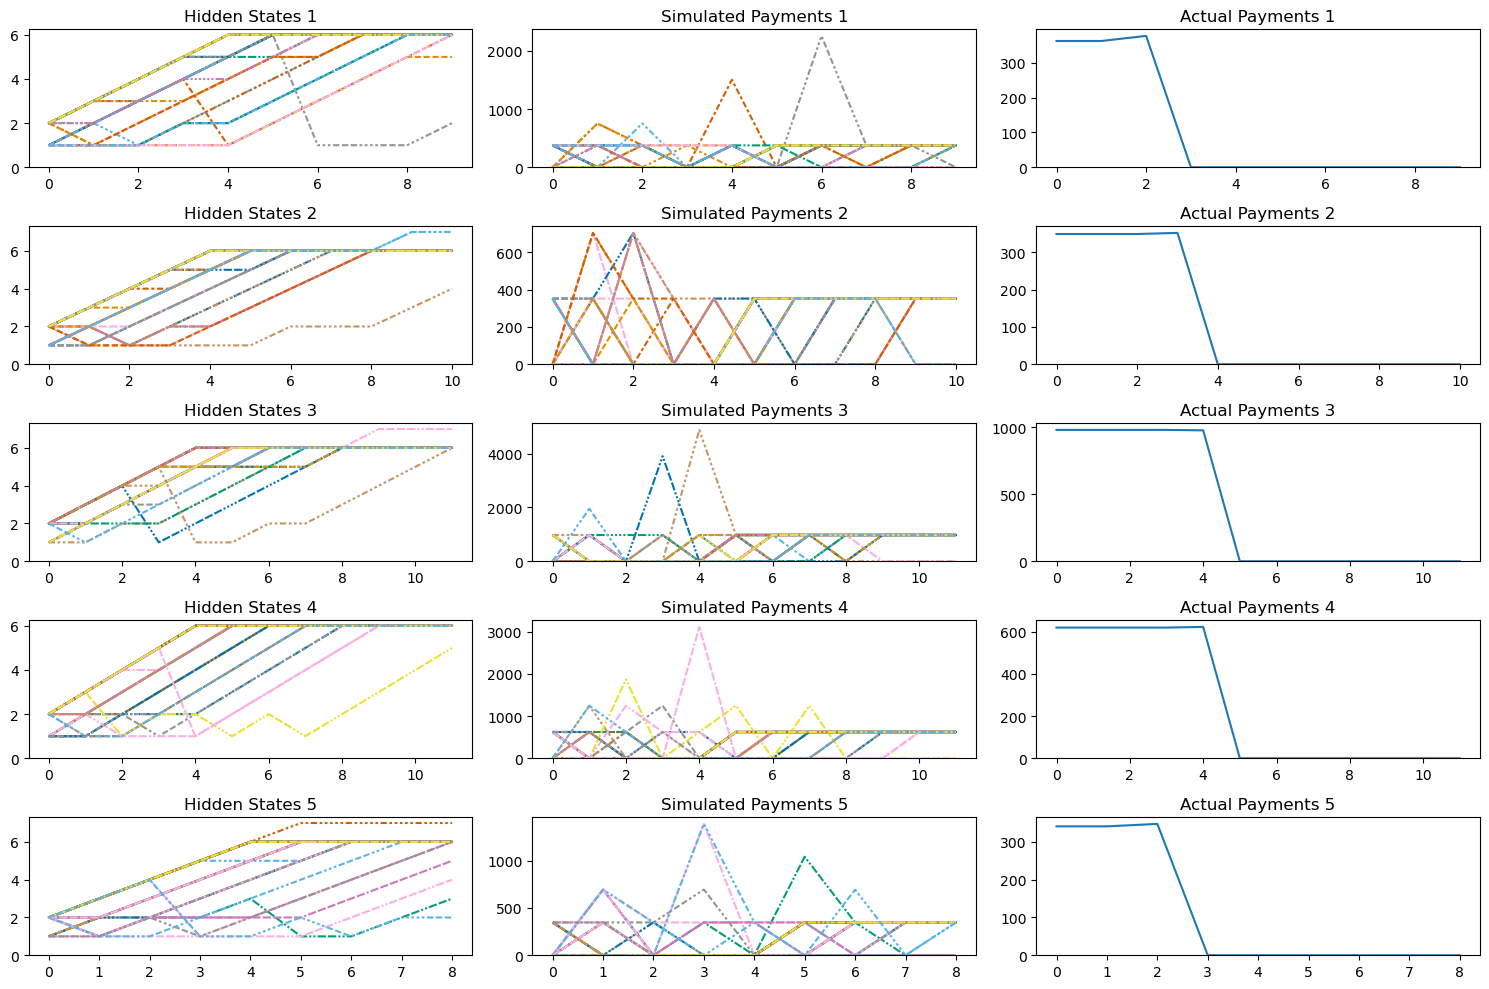

In [30]:
plot_payments(df_tmat_tail)

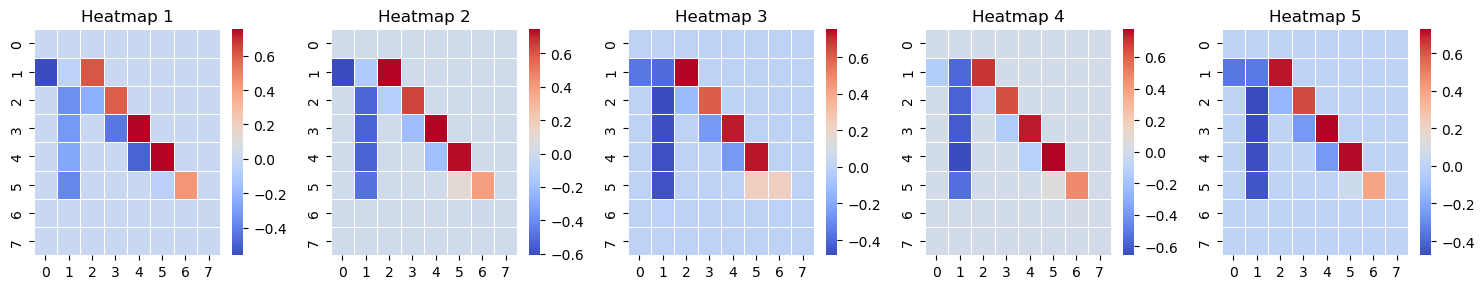

In [31]:
plot_tmat(df_tmat_tail, df_tmat_head)